# Case Study: Telecom Churn

#### Problem Statement:
In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.o reduce customer churn, telecom companies need to predict which customers are at high risk of churn.

#### Business Objective:
In this project, we will analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.

In [1]:
# Suppressing the warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
%matplotlib inline

# Styling the plot
style.use('ggplot')
sns.set_style('whitegrid')

import math
import itertools

import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.preprocessing import StandardScaler, scale
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold,GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_curve, classification_report
from sklearn.metrics import recall_score, precision_score, roc_auc_score, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier

import xgboost
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

import imblearn
from imblearn.over_sampling import SMOTE

In [3]:
# Adjusting the views
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)

In [4]:
# Defining some customized functions which we will use often during this case study

def get_variable_type(element) :
    if element==0:
        return "Not Known"
    elif element < 20 and element!=0 :
        return "Categorical"
    elif element >= 20 and element!=0 :
        return "Contineous" 
    
def get_info(dataframe) :
    infodata_matrix = pd.DataFrame({
                    'Datatype' : dataframe.dtypes.astype(str), 
                    'Non_Null_Count': dataframe.count(axis = 0).astype(int), 
                    'Null_Count': dataframe.isnull().sum().astype(int), 
                    'Null_Percentage': dataframe.isnull().sum()/len(dataframe) * 100, 
                    'Unique_Values_Count': dataframe.nunique().astype(int) 
                     })
    
    infodata_matrix = predict_variable_type(infodata_matrix)
    return infodata_matrix
            
def predict_variable_type(infodata_matrix):
    infodata_matrix["Variable_Type"] = infodata_matrix["Unique_Values_Count"].apply(get_variable_type).astype(str)
    infodata_matrix["frequency"] = infodata_matrix["Null_Count"] - infodata_matrix["Null_Count"]
    infodata_matrix["frequency"].astype(int)
    return infodata_matrix 


def list_potential_categorical_type(dataframe,main) :
    print('Stats for potential categorical datatype columns')
    infodata_matrix_categorical = dataframe[dataframe["Variable_Type"] == "Categorical"]
    # TO DO *** Add check to skip below if there is no Categorical values 
    length = len(infodata_matrix_categorical)
    if length == 0 :
        header_red("No Categorical columns in given dataset.")  
    else :    
        infodata_matrix_categorical = infodata_matrix_categorical.filter(["Datatype","Unique_Values_Count"])
        infodata_matrix_categorical.sort_values(["Unique_Values_Count"], axis=0,ascending=False, inplace=True)
        col_to_check = infodata_matrix_categorical.index.tolist()
        name_list = []
        values_list = []
        for name in col_to_check :
            name_list.append(name)
            values_list.append(main[name].unique())
        temp = pd.DataFrame({"index":name_list,"Unique_Values":values_list})
        infodata_matrix_categorical = infodata_matrix_categorical.reset_index()
        infodata_matrix_categorical = pd.merge(infodata_matrix_categorical,temp,how='inner',on='index')
        display(infodata_matrix_categorical.set_index("index")) 

def plot_data_type_pie_chat(dataframe) : 
        print('Stats for datatype Percentage Distribution')
        dataframe_group = dataframe.groupby("Datatype").frequency.count().reset_index()
        dataframe_group.sort_values(["Datatype"], axis=0,ascending=False, inplace=True)
        trace = go.Pie(labels=dataframe_group["Datatype"].tolist(), values=dataframe_group["frequency"].tolist())
        layout = go.Layout(title="Datatype Percentage Distribution")
        fig = go.Figure(data=[trace], layout=layout)    
        py.offline.iplot(fig)
    
def get_potential_categorical_type(dataframe,main,unique_count) :
    infodata_matrix_categorical = dataframe[dataframe["Variable_Type"] == "Categorical"]
    infodata_matrix_categorical = dataframe[dataframe["Unique_Values_Count"] == unique_count]
    length = len(infodata_matrix_categorical)
    if length == 0 :
        print("No Categorical columns in given dataset.")  
    else :    
        infodata_matrix_categorical = infodata_matrix_categorical.filter(["Datatype","Unique_Values_Count"])
        infodata_matrix_categorical.sort_values(["Unique_Values_Count"], axis=0,ascending=False, inplace=True)
        col_to_check = infodata_matrix_categorical.index.tolist()
        name_list = []
        values_list = []
        for name in col_to_check :
            name_list.append(name)
            values_list.append(main[name].unique())
        temp = pd.DataFrame({"index":name_list,"Unique_Values":values_list})
        infodata_matrix_categorical = infodata_matrix_categorical.reset_index()
        infodata_matrix_categorical = pd.merge(infodata_matrix_categorical,temp,how='inner',on='index')
        display(infodata_matrix_categorical.set_index("index")) 

def heatmap(x,y,dataframe):
    plt.figure(figsize=(x,y))
    sns.heatmap(dataframe.corr(),cmap="YlGnBu",annot=True)
    plt.show()

## 1. Importing the Dataset

In [5]:
# Importing the dataset
telecom = pd.read_csv("telecom_churn_data.csv")
telecom.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,0.00,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,NaN,4.13,NaN,NaN,NaN,1.15,NaN,NaN,NaN,5.44,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,0.00,0.00,5.44,0.00,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,4,3,

In [6]:
# Shape
telecom.shape

(99999, 226)

In churn prediction, we assume that there are three phases of customer lifecycle:
- The 'Good' Phase
- The 'Action' Phase
- The 'Churn' Phase

## 2. Inspecting the DataFrame

In [7]:
# Columns containing recharge amount
amt_recharge_columns =  telecom.columns[telecom.columns.str.contains('rech_amt|rech_data')]
print(amt_recharge_columns)

Index(['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'total_rech_amt_9', 'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8', 'max_rech_amt_9', 'date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8', 'date_of_last_rech_data_9', 'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'total_rech_data_9', 'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8', 'max_rech_data_9', 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'av_rech_amt_data_9'], dtype='object')


`Inference:` Meaningful features:
- Total Recharge Amount
- Total Recharge for Data
- Maximum Recharge Amount
- Average Recharge Amount

In [8]:
# Missing Values Percentage
telecom_df_null_check = 100*telecom.loc[:,amt_recharge_columns].isnull().sum()/len(telecom)
df = pd.DataFrame(telecom_df_null_check)
df.rename(columns={0:'Null_Percentage'}, inplace=True)
df = pd.DataFrame(df.Null_Percentage)
display(df)

,Null_Percentage
total_rech_amt_6,0.000000
total_rech_amt_7,0.000000
total_rech_amt_8,0.000000
total_rech_amt_9,0.000000
max_rech_amt_6,0.000000
max_rech_amt_7,0.000000
max_rech_amt_8,0.000000
max_rech_amt_9,0.000000
date_of_last_rech_data_6,74.846748
date_of_last_rech_data_7,74.428744


`Inference:`
- We can see that there are columns with more than 70% missing values.

In [9]:
telecom.loc[:,amt_recharge_columns].describe()

,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9
count,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,25153.000000,25571.000000,26339.000000,25922.000000,25153.000000,25571.000000,26339.000000,25922.00000,25153.000000,25571.000000,26339.000000,25922.000000
mean,327.514615,322.962970,324.157122,303.345673,104.637486,104.752398,107.728207,101.943889,2.463802,2.666419,2.651999,2.441170,126.393392,126.729459,125.717301,124.94144,192.600982,200.981292,197.526489,192.734315
std,398.019701,408.114237,416.540455,404.588583,120.614894,124.523970,126.902505,125.375109,2.789128,3.031593,3.074987,2.516339,108.477235,109.765267,109.437851,111.36376,192.646318,196.791224,191.301305,188.400286
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,0.500000,0.500000,1.000000
25%,109.000000,100.000000,90.000000,52.000000,30.000000,30.000000,30.000000,28.000000,1.000000,1.000000,1.000000,1.000000,25.000000,25.000000,25.000000,25.00000,82.000000,92.000000,87.000000,69.000000
50%,230.000000,220.000000,225.000000,200.000000,110.000000,110.000000,98.000000,61.000000,1.000000,1.000000,1.000000,2.000000,145.000000,145.000000,145.000000,145.00000,154.000000,154.000000,154.000000,164.000000
75%,437.500000,428.000000,434.500000,415.000000,120.000000,128.000000,144.000000,144.000000,3.000000,3.000000,3.000000,3.000000,177.000000,177.000000,179.000000,179.00000,252.000000,252.000000,252.000000,252.000000
max,35190.000000,40335.000000,45320.000000,37235.000000,4010.000000,4010.000000,4449.000000,3399.000000,61.000000,54.000000,60.000000,84.000000,1555.000000,1555.000000,1555.000000,1555.00000,7546.000000,4365.000000,4076.000000,4061.000000


`Inference:`
- As the minimum value is 1, we can impute NA values by 0, considering no recharge was done.

In [10]:
# Replacing Null values with 0
telecom['total_rech_data_6'] = telecom['total_rech_data_6'].replace(np.NaN,0.0)
telecom['total_rech_data_7'] = telecom['total_rech_data_7'].replace(np.NaN,0.0)
telecom['total_rech_data_8'] = telecom['total_rech_data_8'].replace(np.NaN,0.0)

In [11]:
# Replacing Null values with 0
telecom['av_rech_amt_data_6'] = telecom['av_rech_amt_data_6'].replace(np.NaN,0.0)
telecom['av_rech_amt_data_7'] = telecom['av_rech_amt_data_7'].replace(np.NaN,0.0)
telecom['av_rech_amt_data_8'] = telecom['av_rech_amt_data_8'].replace(np.NaN,0.0)

In [12]:
# 'total_rech_amt_data' for calculating High Value customer process
telecom['total_rech_amt_data_6'] = telecom.av_rech_amt_data_6 * telecom.total_rech_data_6
telecom['total_rech_amt_data_7'] = telecom.av_rech_amt_data_7 * telecom.total_rech_data_7
telecom['total_rech_amt_data_8'] = telecom.av_rech_amt_data_8 * telecom.total_rech_data_8

In [13]:
# Average recharge amount for the Good Phase
telecom['total_avg_rech_amt_6_7_GPhase'] = (telecom.total_rech_amt_6 + telecom.total_rech_amt_data_6 \
                                               + telecom.total_rech_amt_7+ telecom.total_rech_amt_data_7)/2

## 3. Filtering High Value Customers
People who have done recharge of amount more than the 70th percentile of average recharge amount.

In [14]:
# create a filter for values greater than 70th percentile of total average recharge amount for good phase 
high_value_filter = telecom.total_avg_rech_amt_6_7_GPhase.quantile(0.7)
print('70th Percentile:', high_value_filter)

telecom_high_val_cust = telecom[telecom.total_avg_rech_amt_6_7_GPhase > high_value_filter]
print('Shape of Telecom High Value Customers:', telecom_high_val_cust.shape)

70th Percentile: 478.0
Shape of Telecom High Value Customers: (29953, 230)


### Tag Churners and removal of attributes of churn phase

- Now tagging the churned customers (churn=1, else 0) based on the fourth month as follows: Those who have not made any calls and have not used mobile internet even once in the churn phase.
- The attributes we need to use to tag churners are:total_ic_mou_9, total_og_mou_9, vol_2g_mb_9, vol_3g_mb_9
- After tagging churners, remove all the attributes corresponding to the churn phase (all attributes having ‘ _9’, etc. in their names).

In [15]:
high_val_cust_9 = ['total_ic_mou_9', 'total_og_mou_9', 'vol_2g_mb_9','vol_3g_mb_9']

In [16]:
# Missing Value Percentage
df = 100*telecom_high_val_cust.loc[:,high_val_cust_9].isnull().sum()/len(telecom_high_val_cust)
df = pd.DataFrame(df)
df.rename(columns={0:'Null_Percentage'}, inplace=True)
df = pd.DataFrame(df.Null_Percentage)
display(df)

,Null_Percentage
total_ic_mou_9,0.0
total_og_mou_9,0.0
vol_2g_mb_9,0.0
vol_3g_mb_9,0.0


In [17]:
# Initialising 'churn' variable as 0
telecom_high_val_cust['churn']= 0

In [18]:
# Using is_churned boolean flag for customers where above values are zero
is_churned = (telecom_high_val_cust.total_ic_mou_9 == 0) & \
             (telecom_high_val_cust.total_og_mou_9 == 0) & \
             (telecom_high_val_cust.vol_2g_mb_9 ==0) & \
             (telecom_high_val_cust.vol_3g_mb_9 ==0)

In [19]:
# Turning all the churned from 0 to 1
telecom_high_val_cust.loc[is_churned,'churn']=1

In [20]:
# Checking percentage of churned customers
print('Churn Percentage:', round((telecom_high_val_cust.churn.sum()/len(telecom_high_val_cust))*100, 2))

Churn Percentage: 8.12


In [21]:
# Removing attributes containing '_9'
churn_month_columns =  telecom_high_val_cust.columns[telecom_high_val_cust.columns.str.contains('_9')]

telecom_high_val_cust.drop(churn_month_columns,axis=1,inplace=True)

## 4. Exploratory Data Analysis

In [22]:
list_potential_categorical_type(get_info(telecom_high_val_cust),telecom_high_val_cust)

Stats for potential categorical datatype columns


,Datatype,Unique_Values_Count,Unique_Values
index,,,
monthly_3g_7,int64,15,"[1, 0, 2, 5, 3, 8, 4, 7, 6, 9, 11, 12, 14, 10,..."
monthly_3g_8,int64,12,"[1, 0, 2, 7, 3, 4, 6, 5, 8, 10, 9, 16]"
monthly_3g_6,int64,12,"[1, 0, 4, 2, 3, 5, 7, 6, 9, 8, 11, 14]"
monthly_2g_8,int64,6,"[0, 1, 2, 5, 3, 4]"
monthly_2g_7,int64,6,"[0, 1, 2, 5, 4, 3]"
monthly_2g_6,int64,5,"[0, 2, 1, 3, 4]"
night_pck_user_6,float64,2,"[0.0, nan, 1.0]"
night_pck_user_7,float64,2,"[0.0, nan, 1.0]"
fb_user_8,float64,2,"[1.0, nan, 0.0]"


In [23]:
# Dropping columns with one unique value
drop_col_with_unique_col =['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 
                          'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 
                          'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 
                          'std_og_t2c_mou_8',  'std_ic_t2o_mou_6', 
                          'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8']

telecom_high_val_cust.drop(drop_col_with_unique_col,axis=1,inplace=True)

print('Shape:', telecom_high_val_cust.shape)

Shape: (29953, 164)


In [24]:
info_df = get_info(telecom_high_val_cust)

In [25]:
# Date Columns
info_df_count = info_df[info_df["Datatype"] == 'object']
date_col = info_df_count.index.tolist()
date_col

['date_of_last_rech_6',
 'date_of_last_rech_7',
 'date_of_last_rech_8',
 'date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8']

In [26]:
telecom_high_val_cust[date_col].head(5)

,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8
0,6/21/2014,7/16/2014,8/8/2014,6/21/2014,7/16/2014,8/8/2014
7,6/27/2014,7/25/2014,8/26/2014,NaN,NaN,NaN
8,6/25/2014,7/31/2014,8/30/2014,NaN,7/31/2014,8/23/2014
21,6/30/2014,7/31/2014,8/31/2014,NaN,NaN,NaN
23,6/18/2014,7/7/2014,8/24/2014,NaN,7/7/2014,8/6/2014


In [27]:
for col in date_col:
    telecom_high_val_cust[col] = pd.to_datetime(telecom_high_val_cust[col])

In [28]:
telecom_high_val_cust.head()

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8,total_avg_rech_amt_6_7_GPhase,churn
0,7000842753,197.385,214.816,213.803,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.0,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,4.13,NaN,NaN,1.15,NaN,NaN,5.44,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,0.00,0.00,5.44,NaN,NaN,0.0,NaN,NaN,0.00,NaN,NaN,0.00,4,3,2,362,252,252,252,252,252,2014-06-21,2014-07-16,2014-08-08,252,252,252,2014-06-21,2014-07-16,2014-08-08,1.0,1.0,1.0,252.0,252.0,252.0,0.0,0.0,0.0,1.0,1.0,1.0,252.0,252.0,252.0,30.13,1.32,5.75,83.57,150.76,109.61,212.17,212.17,212.17,212.17,212.17,212.17,0.0,0.0,0.0,0,0,0,0,0,0,1,1,1,0,0,0,1.0,1.0,1.0,968,30.40,0.00,101.20,3.58,252.0,252.0,252.0,559.0,1
7,7000701601,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.0,0.0,0.00,422.16,533.91,255.79,4.30,23.29,12.01,49.89,31.76,49.14,6.66,20.08,16.68,60.86,75.14,77.84,0.0,0.18,10.01,4.5,0.0,6.50,0.0,0.0,0.0,487.53,609.24,350.16,58.14,32.26,27.31,217.56,221.49,121.19,152.16,101.46,39.53,427.88,355.23,188.04,36.89,11.83,30.39,91.44,126.99,141.33,52.19,34.24,22.21,180.54,173.08,193.94,626.46,558.04,428.74,0.21,0.0,0.0,2.06,14.53,31.59,15.74,15.19,15.14,5,5,7,1580,790,3638,1580,790,1580,2014-06-27,2014-07-25,2014-08-26,0,0,779,NaT,NaT,NaT,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,

In [29]:
list_potential_categorical_type(get_info(telecom_high_val_cust),telecom_high_val_cust)

Stats for potential categorical datatype columns


,Datatype,Unique_Values_Count,Unique_Values
index,,,
monthly_3g_7,int64,15,"[1, 0, 2, 5, 3, 8, 4, 7, 6, 9, 11, 12, 14, 10,..."
monthly_3g_6,int64,12,"[1, 0, 4, 2, 3, 5, 7, 6, 9, 8, 11, 14]"
monthly_3g_8,int64,12,"[1, 0, 2, 7, 3, 4, 6, 5, 8, 10, 9, 16]"
monthly_2g_7,int64,6,"[0, 1, 2, 5, 4, 3]"
monthly_2g_8,int64,6,"[0, 1, 2, 5, 3, 4]"
monthly_2g_6,int64,5,"[0, 2, 1, 3, 4]"
night_pck_user_6,float64,2,"[0.0, nan, 1.0]"
night_pck_user_7,float64,2,"[0.0, nan, 1.0]"
night_pck_user_8,float64,2,"[0.0, nan, 1.0]"


In [30]:
# Defining function for boxplots for months 6-8
def plot_box_chart(attribute):
    plt.figure(figsize=(20,16))
    df = telecom_high_val_cust
    plt.subplot(2,3,1)
    sns.boxplot(data=df, y=attribute+"_6",x="churn",hue="churn",
                showfliers=False,palette=("plasma"))
    plt.subplot(2,3,2)
    sns.boxplot(data=df, y=attribute+"_7",x="churn",hue="churn",
                showfliers=False,palette=("plasma"))
    plt.subplot(2,3,3)
    sns.boxplot(data=df, y=attribute+"_8",x="churn",hue="churn",
                showfliers=False,palette=("plasma"))
    plt.show()

In [31]:
# Recharge Amount Columns
recharge_amnt_columns =  telecom_high_val_cust.columns[telecom_high_val_cust.columns.str.contains('rech_amt')]
recharge_amnt_columns.tolist()

['total_rech_amt_6',
 'total_rech_amt_7',
 'total_rech_amt_8',
 'max_rech_amt_6',
 'max_rech_amt_7',
 'max_rech_amt_8',
 'av_rech_amt_data_6',
 'av_rech_amt_data_7',
 'av_rech_amt_data_8',
 'total_rech_amt_data_6',
 'total_rech_amt_data_7',
 'total_rech_amt_data_8',
 'total_avg_rech_amt_6_7_GPhase']

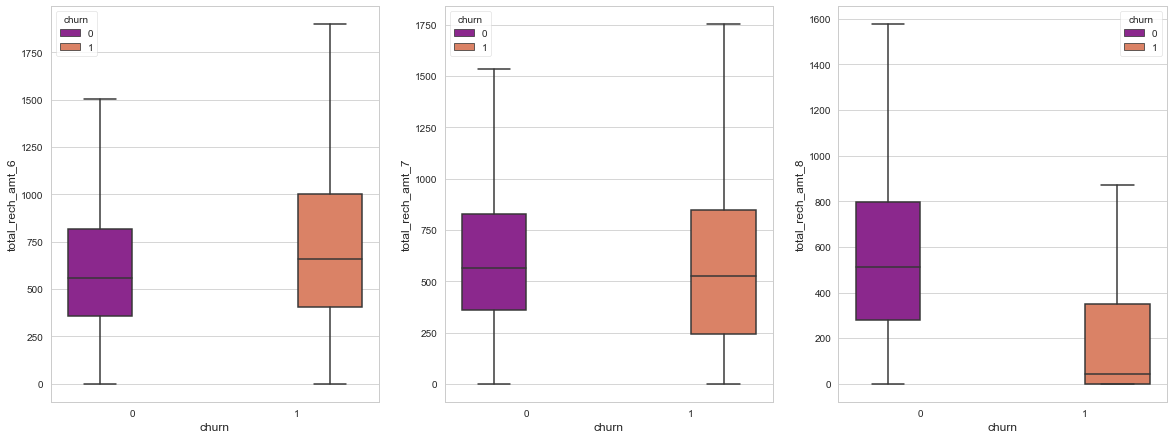

In [32]:
# total recharge amount:
plot_box_chart('total_rech_amt')

`Inference:`
- We can see a drop of Recharge amount for the churned customers in the 8th month

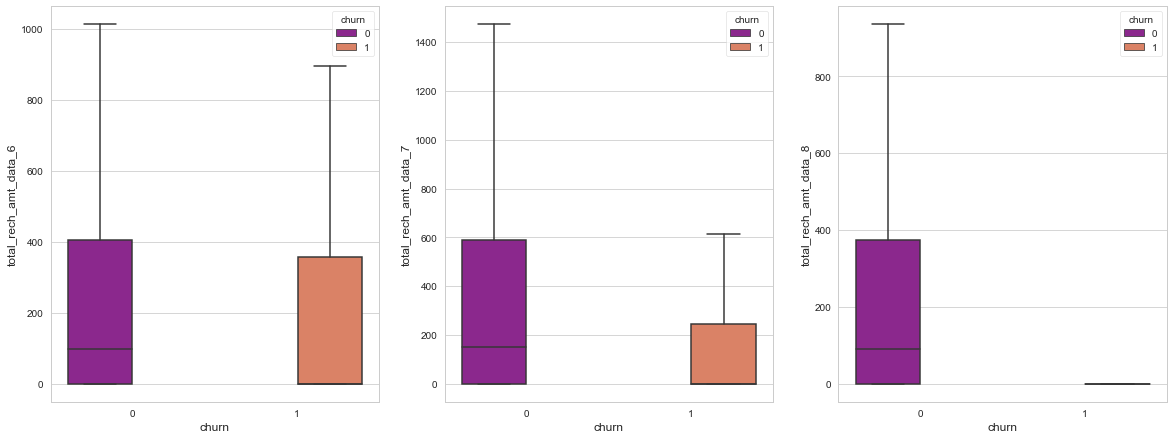

In [33]:
# total recharge amount for data:
plot_box_chart('total_rech_amt_data')

`Inference:`
- We can see a drop of Recharge amount for data for the churned cutsomers in the 8th month.

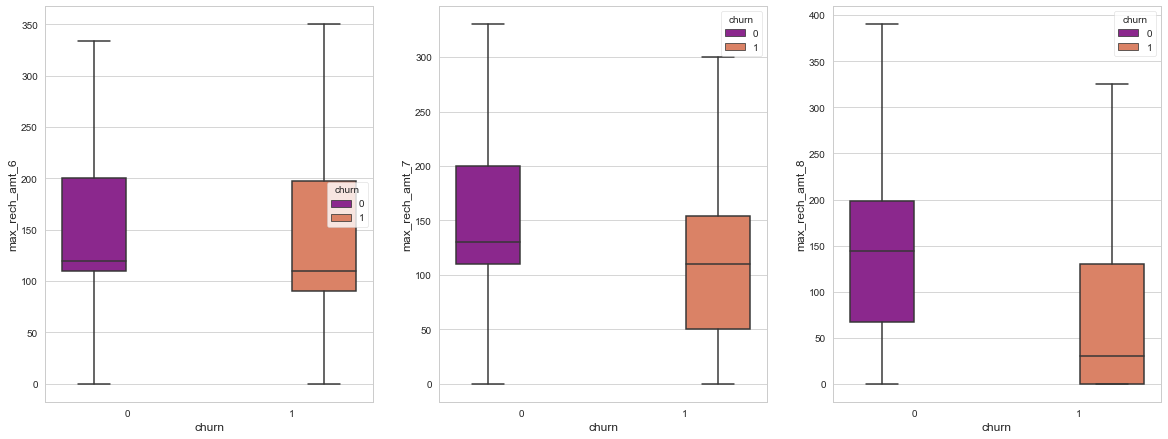

In [34]:
# maximum recharge amount for data:
plot_box_chart('max_rech_amt')

`Inference:`
- We can see a drop of Max Recharge amount for the churned cutsomers in the 8th month.

In [35]:
# Checking other recharge related variables:
other_recharge = telecom_high_val_cust.columns[telecom_high_val_cust.columns.str.contains('rech_num|max_rech_data',regex=True)]

In [36]:
# Null Value Percentage
(telecom_high_val_cust.loc[:,other_recharge].isnull().sum()/len(telecom_high_val_cust))*100

total_rech_num_6     0.000000
total_rech_num_7     0.000000
total_rech_num_8     0.000000
max_rech_data_6     44.112443
max_rech_data_7     43.117551
max_rech_data_8     46.799987
dtype: float64

In [37]:
telecom_high_val_cust.loc[:,['max_rech_data_6','max_rech_data_7','max_rech_data_8']].describe()

,max_rech_data_6,max_rech_data_7,max_rech_data_8
count,16740.000000,17038.000000,15935.000000
mean,139.804002,140.444712,136.353373
std,118.892926,120.295284,119.571138
min,1.000000,1.000000,1.000000
25%,25.000000,25.000000,25.000000
50%,152.000000,152.000000,152.000000
75%,198.000000,198.000000,198.000000
max,1555.000000,1555.000000,1555.000000


`Inference:`
- Minimum recharge value is 1. So, we can fill the missing values with 0 indicating that recharge didn't happen.

In [38]:
# Replacing NA's with 0
telecom_high_val_cust.loc[:,['max_rech_data_6','max_rech_data_7','max_rech_data_8']] \
= telecom_high_val_cust.loc[:,['max_rech_data_6','max_rech_data_7','max_rech_data_8']].replace(np.nan,0)

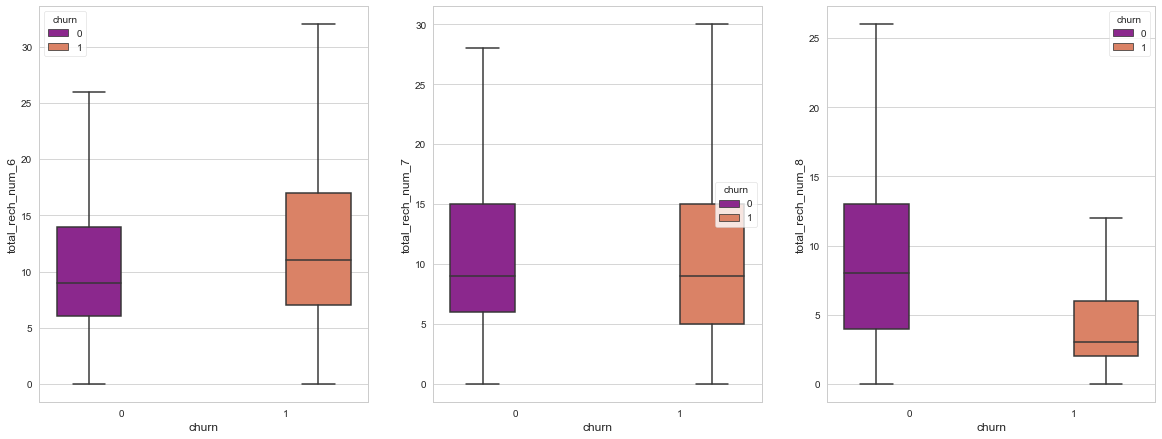

In [39]:
# Total recharge for Number:
plot_box_chart('total_rech_num')

`Inference:`
- We can see a drop of total Recharge number for the churned cutsomers in the 8th month.

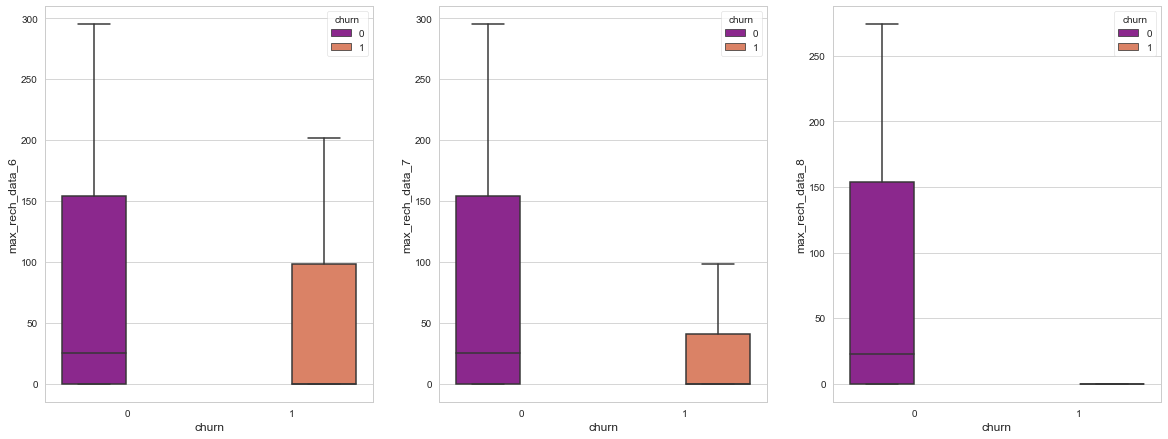

In [40]:
# maximum recharge for data:
plot_box_chart('max_rech_data')

`Inference:`
- We can see a drop of Max Recharge data for the churned cutsomers in the 8th month.

In [41]:
# last day recharge amount columns
last_day_rech_amt = telecom_high_val_cust.columns[telecom_high_val_cust.columns.str.contains('day')]
last_day_rech_amt.tolist()

['last_day_rch_amt_6', 'last_day_rch_amt_7', 'last_day_rch_amt_8']

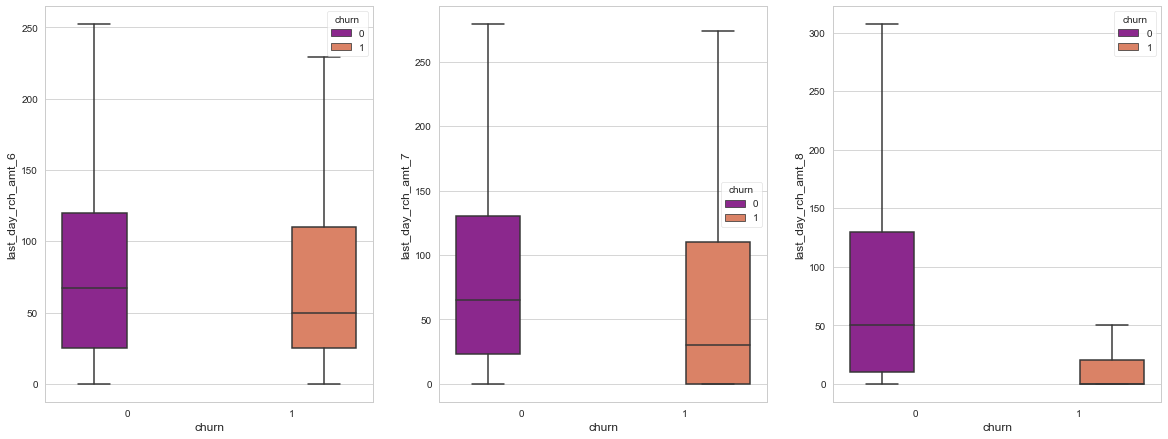

In [42]:
# last day recharge amount:
plot_box_chart('last_day_rch_amt')

`Inference:`
- We can see a huge drop in the 8th month

In [43]:
usage_2g_and_3g = telecom_high_val_cust.columns[telecom_high_val_cust.columns.str.contains('2g|3g',regex=True)]

In [44]:
# Missing Value Percentage
percentage_3g_2g_null_check = 100*telecom_high_val_cust.loc[:,usage_2g_and_3g].isnull().sum()/len(telecom_high_val_cust.loc[:,usage_2g_and_3g])
df = pd.DataFrame(percentage_3g_2g_null_check)
df.rename(columns={0:'Null_Percentage'}, inplace=True)
df = pd.DataFrame(df.Null_Percentage)
display(df)

,Null_Percentage
count_rech_2g_6,44.112443
count_rech_2g_7,43.117551
count_rech_2g_8,46.799987
count_rech_3g_6,44.112443
count_rech_3g_7,43.117551
count_rech_3g_8,46.799987
vol_2g_mb_6,0.000000
vol_2g_mb_7,0.000000
vol_2g_mb_8,0.000000
vol_3g_mb_6,0.000000


`Inference:` Dropping the columns with more than 40% missing values

In [45]:
# Dropping
telecom_high_val_cust.drop(['count_rech_2g_6','count_rech_2g_7',
              'count_rech_2g_8','count_rech_3g_6','count_rech_3g_7','count_rech_3g_8'
               ,'arpu_3g_6','arpu_3g_7','arpu_3g_8','arpu_2g_6','arpu_2g_7','arpu_2g_8'],axis=1,inplace=True)

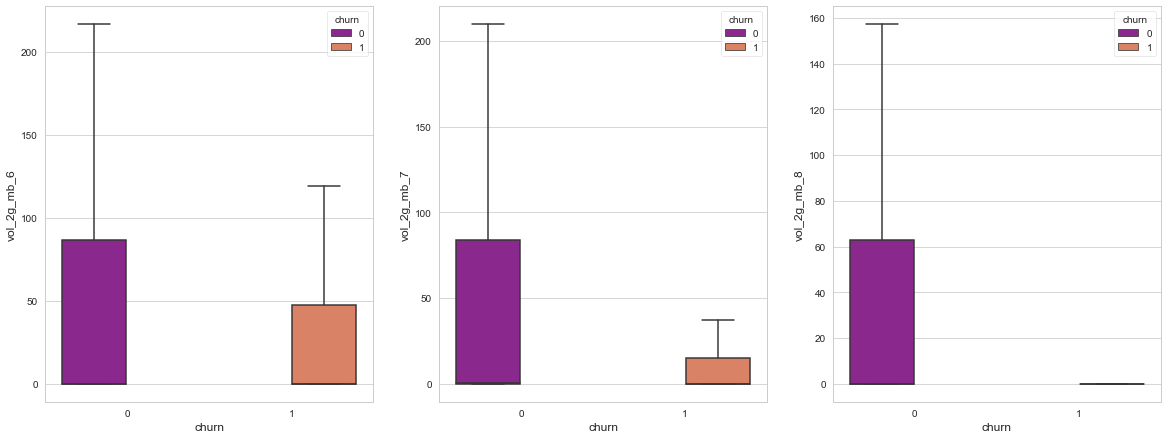

In [46]:
# 2G usage
plot_box_chart('vol_2g_mb')

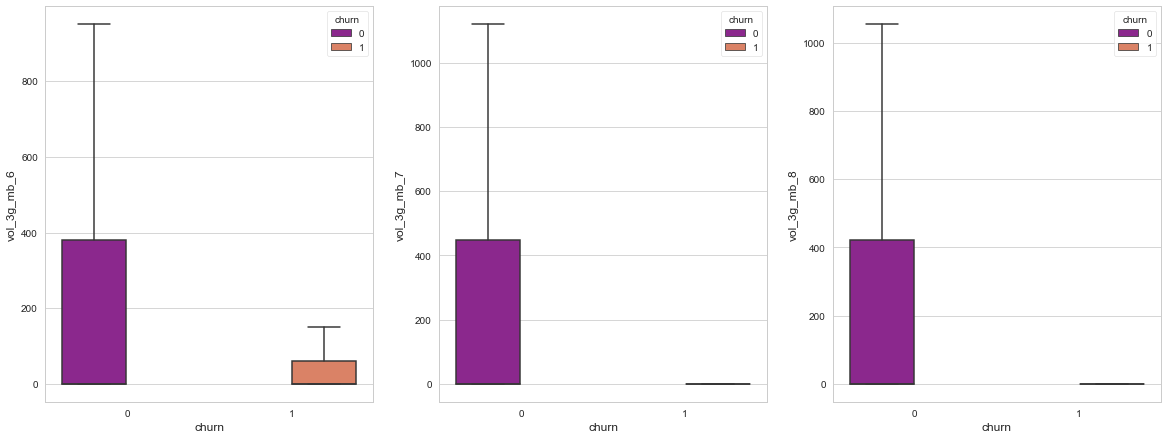

In [47]:
# 3G usage
plot_box_chart('vol_3g_mb')

`Inference:`
- 2G and 3G usage for churned customers drops in the 8th month.

In [48]:
# 2G/3G service schemes
monthly_subcription_2g_3g = telecom_high_val_cust.columns[telecom_high_val_cust.columns.str.contains('monthly_2g|monthly_3g',regex=True)]
monthly_subcription_2g_3g.tolist()

['monthly_2g_6',
 'monthly_2g_7',
 'monthly_2g_8',
 'monthly_3g_6',
 'monthly_3g_7',
 'monthly_3g_8']

In [49]:
telecom_high_val_cust[monthly_subcription_2g_3g].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29953 entries, 0 to 99997
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   monthly_2g_6  29953 non-null  int64
 1   monthly_2g_7  29953 non-null  int64
 2   monthly_2g_8  29953 non-null  int64
 3   monthly_3g_6  29953 non-null  int64
 4   monthly_3g_7  29953 non-null  int64
 5   monthly_3g_8  29953 non-null  int64
dtypes: int64(6)
memory usage: 2.6 MB


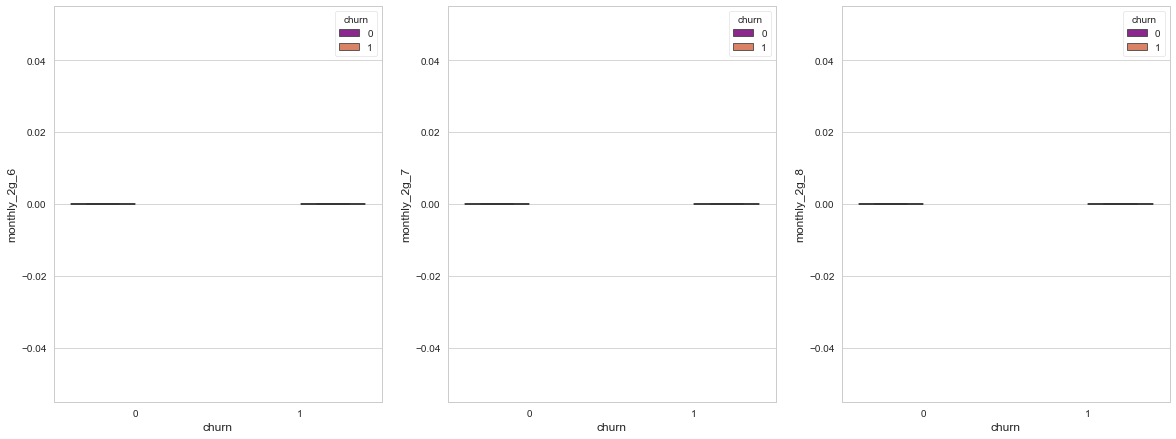

In [50]:
# Monthly subscription :
plot_box_chart('monthly_2g')

In [51]:
# Plotting mean bar chart since, boxplot is not suitable here.
def plot_mean_bar_chart(df,columns_list):
    df_0 = df[df.churn==0].filter(columns_list)
    df_1 = df[df.churn==1].filter(columns_list)

    mean_df_0 = pd.DataFrame([df_0.mean()],index={'Non Churn'})
    mean_df_1 = pd.DataFrame([df_1.mean()],index={'Churn'})

    frames = [mean_df_0, mean_df_1]
    mean_bar = pd.concat(frames)

    mean_bar.T.plot.bar(figsize=(10,5),rot=0)
    plt.show()
    
    return mean_bar

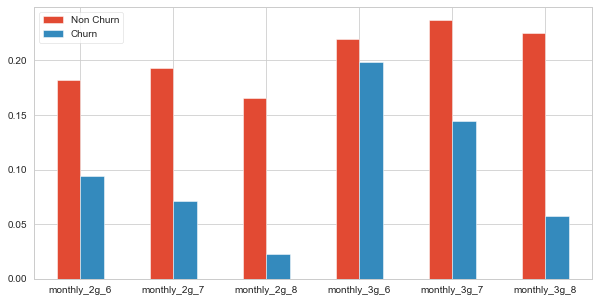

,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8
Non Churn,0.181613,0.193096,0.165080,0.219840,0.236882,0.224891
Churn,0.093711,0.071106,0.023017,0.198109,0.144266,0.057131


In [52]:
plot_mean_bar_chart(telecom_high_val_cust, monthly_subcription_2g_3g)

`Inference:`
- We can see a drop in monthly subscription for churned customers in 8th month.

In [53]:
# Volume based cost 
vbc_column = telecom_high_val_cust.columns[telecom_high_val_cust.columns.str.contains('vbc_',regex=True)]
vbc_column.tolist()

['aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g']

In [54]:
# Renaming month named vbc columns to 6,7,8,9 format
telecom_high_val_cust.rename(columns={'jun_vbc_3g':'vbc_3g_6','jul_vbc_3g':'vbc_3g_7','aug_vbc_3g':'vbc_3g_8'
                         ,'sep_vbc_3g':'vbc_3g_9'}, inplace=True)

# Drop 9th month column as it is not needed
telecom_high_val_cust.drop('vbc_3g_9',axis=1,inplace=True)

In [55]:
vbc_column = telecom_high_val_cust.columns[telecom_high_val_cust.columns.str.contains('vbc_3g',regex=True)]
vbc_column.tolist()

['vbc_3g_8', 'vbc_3g_7', 'vbc_3g_6']

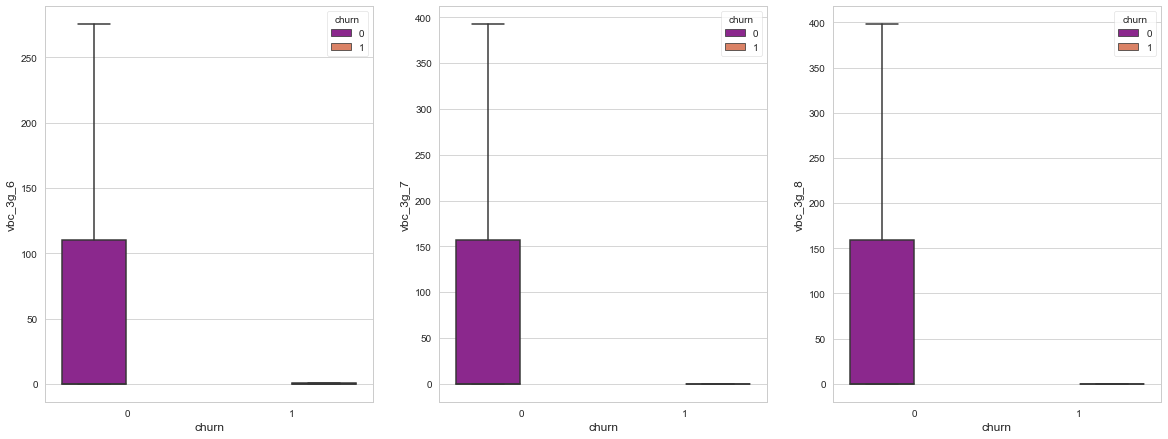

In [56]:
# Volume based cost :
plot_box_chart('vbc_3g')

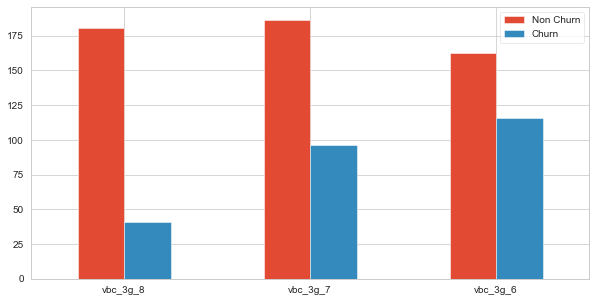

,vbc_3g_8,vbc_3g_7,vbc_3g_6
Non Churn,180.622636,186.370503,162.557305
Churn,40.940884,96.340707,115.461780


In [57]:
plot_mean_bar_chart(telecom_high_val_cust, vbc_column)

`Inference:`
- We can see that volume based cost for 3G is much lower for Churned customers as compared to Non-Churn Customers

In [58]:
# Checking Service schemes with validity smaller than a month for 2G/3G
SC_2g_or_3g_col = telecom_high_val_cust.columns[telecom_high_val_cust.columns.str.contains('sachet_2g|sachet_3g',regex=True)]

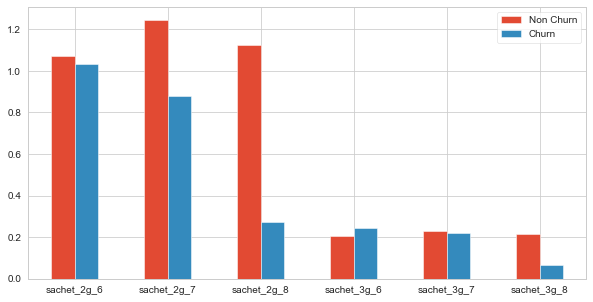

,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8
Non Churn,1.070531,1.245203,1.125145,0.206577,0.228307,0.214571
Churn,1.032470,0.879984,0.270859,0.244554,0.221948,0.065351


In [59]:
plot_mean_bar_chart(telecom_high_val_cust, SC_2g_or_3g_col)

`Inference:` We can see the drop in sachet services for churned customers in 8th month.

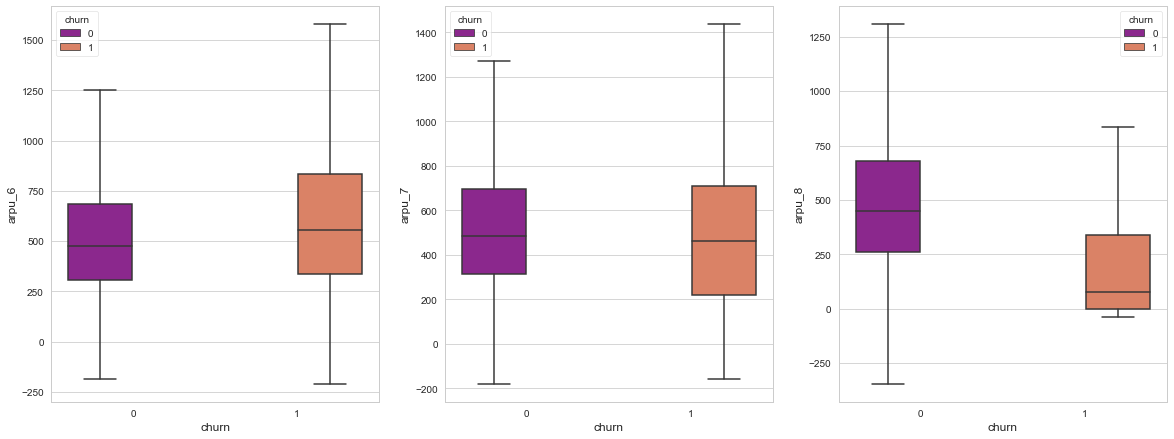

In [60]:
# Checking columns for average revenue per user
arpu_cols = telecom_high_val_cust.columns[telecom_high_val_cust.columns.str.contains('arpu_')]

# Plotting arpu
plot_box_chart('arpu')

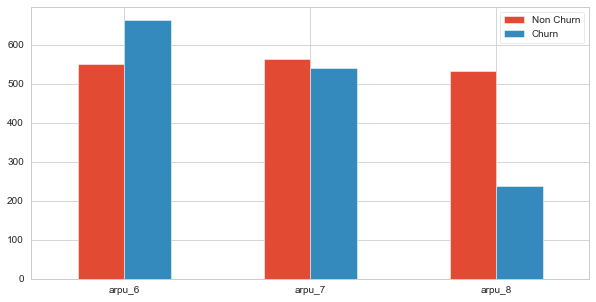

,arpu_6,arpu_7,arpu_8
Non Churn,549.546959,562.929990,532.869746
Churn,663.709368,541.146131,237.655478


In [61]:
plot_mean_bar_chart(telecom_high_val_cust, arpu_cols)

`Inference:`
- We can see huge drops for Arpu in 8th month

In [62]:
# Minutes of Usage
mou_cols = telecom_high_val_cust.columns[telecom_high_val_cust.columns.str.contains('mou')]
mou_cols

Index(['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8',
       'loc_

In [63]:
info_df = get_info(telecom_high_val_cust[mou_cols])
info_df.sort_values(["Null_Percentage"], axis=0,ascending=False, inplace=True)
col_to_display = ['Null_Percentage']
info_df[col_to_display]

,Null_Percentage
isd_ic_mou_8,3.912797
loc_ic_t2t_mou_8,3.912797
loc_ic_t2m_mou_8,3.912797
std_og_t2t_mou_8,3.912797
loc_og_t2c_mou_8,3.912797
loc_ic_t2f_mou_8,3.912797
loc_og_t2f_mou_8,3.912797
loc_ic_mou_8,3.912797
std_og_mou_8,3.912797
loc_og_t2m_mou_8,3.912797


`Inference:`
- Missing value in mou columns is more than 3%.

In [64]:
# Replaceing null values by 0 for mou variables
telecom_high_val_cust.loc[:,mou_cols] = telecom_high_val_cust.loc[:,mou_cols].replace(np.NaN,0)

In [65]:
mou_og_cols6 = telecom_high_val_cust.columns[telecom_high_val_cust.columns.str.contains('.*_og_.*mou_6',regex=True)]

In [66]:
telecom_high_val_cust.loc[:,mou_og_cols6].describe()

,roam_og_mou_6,loc_og_t2t_mou_6,loc_og_t2m_mou_6,loc_og_t2f_mou_6,loc_og_t2c_mou_6,loc_og_mou_6,std_og_t2t_mou_6,std_og_t2m_mou_6,std_og_t2f_mou_6,std_og_mou_6,isd_og_mou_6,spl_og_mou_6,total_og_mou_6
count,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000
mean,26.596033,84.574122,163.309546,6.348347,1.577380,254.240239,165.897941,179.439168,1.806292,347.147123,2.174995,5.825077,610.058005
std,116.274169,228.962993,250.218928,22.139546,6.308138,378.546516,403.990737,409.143255,11.988810,608.845412,45.888834,17.579228,691.178402
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.380000,19.210000,0.000000,0.000000,32.260000,0.000000,0.000000,0.000000,0.400000,0.000000,0.000000,116.640000
50%,0.000000,24.360000,77.260000,0.000000,0.000000,124.590000,2.710000,16.360000,0.000000,45.080000,0.000000,0.230000,410.630000
75%,0.000000,78.060000,209.030000,4.230000,0.000000,332.310000,109.560000,154.540000,0.000000,465.290000,0.000000,5.210000,859.030000
max,3775.110000,6431.330000,4729.740000,1466.030000,271.440000,10643.380000,7366.580000,8314.760000,628.560000,8432.990000,5900.660000,1023.210000,10674.030000


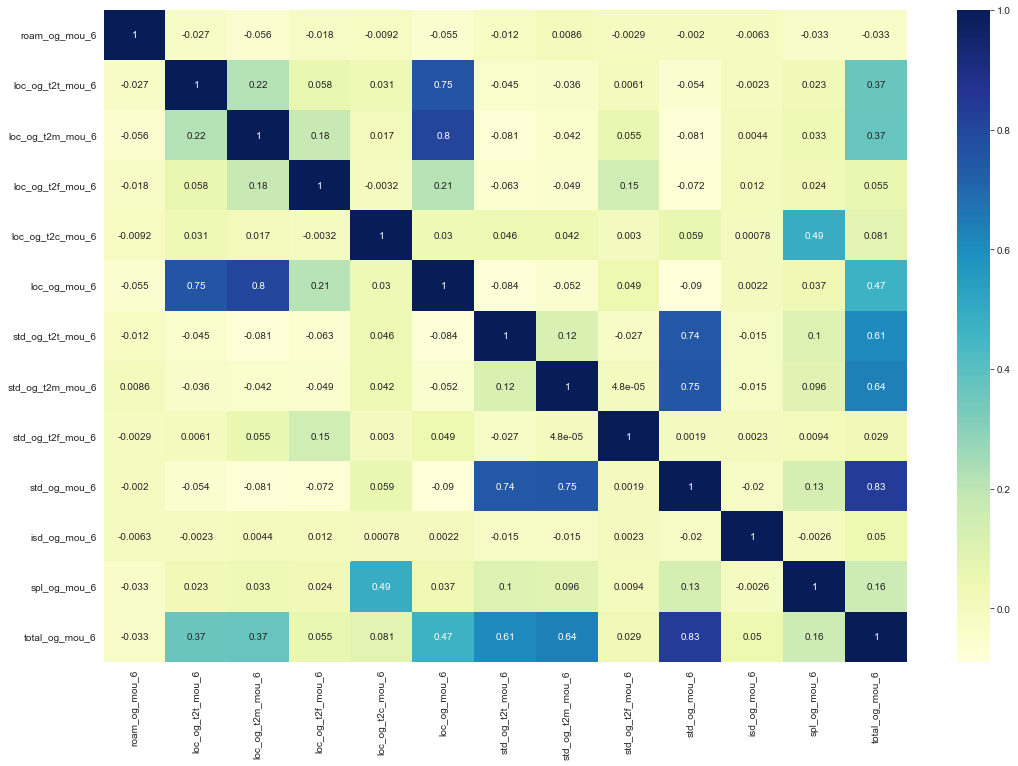

In [67]:
# Correlation matrix
heatmap(18,12,telecom_high_val_cust.filter(mou_og_cols6))

`Inference:`
- We can see that total_og_mou_6, std_og_mou_6 and loc_og_mou_6 have high correlations with some variables and they should be inspected.

In [68]:
# Dropping some columns
list_total_og_cols = telecom_high_val_cust.columns[telecom_high_val_cust.columns.str.contains('total_og_mou|std_og_mou|loc_og_mou',regex=True)]
telecom_high_val_cust.drop(list_total_og_cols,axis=1,inplace=True)
print('Columns Dropped:')
list_total_og_cols.tolist()

Columns Dropped:


['loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 'total_og_mou_6',
 'total_og_mou_7',
 'total_og_mou_8']

In [69]:
# Checking incoming mou variables
mou_ic_cols6 = telecom_high_val_cust.columns[telecom_high_val_cust.columns.str.contains('.*_ic_.*mou_6',regex=True)]
telecom_high_val_cust.loc[:,mou_ic_cols6].describe()

,roam_ic_mou_6,loc_ic_t2t_mou_6,loc_ic_t2m_mou_6,loc_ic_t2f_mou_6,loc_ic_mou_6,std_ic_t2t_mou_6,std_ic_t2m_mou_6,std_ic_t2f_mou_6,std_ic_mou_6,total_ic_mou_6,spl_ic_mou_6,isd_ic_mou_6
count,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000
mean,16.124001,65.508916,150.474219,15.291721,231.284489,14.896832,29.212448,2.698829,46.811695,290.121569,0.061047,10.800999
std,76.344227,163.855393,219.321437,45.785255,315.005426,77.750215,98.279300,19.114766,137.597749,365.739944,0.188124,76.789627
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,6.100000,28.090000,0.000000,47.910000,0.000000,0.000000,0.000000,1.030000,72.890000,0.000000,0.000000
50%,0.000000,25.080000,84.110000,1.840000,134.560000,0.380000,5.000000,0.000000,11.410000,183.780000,0.000000,0.000000
75%,0.000000,67.480000,188.740000,11.980000,297.260000,8.190000,23.630000,0.110000,41.490000,372.160000,0.000000,0.000000
max,2613.310000,6351.440000,4693.860000,1678.410000,7454.630000,5459.560000,4630.230000,1351.110000,5459.630000,7716.140000,19.760000,6789.410000


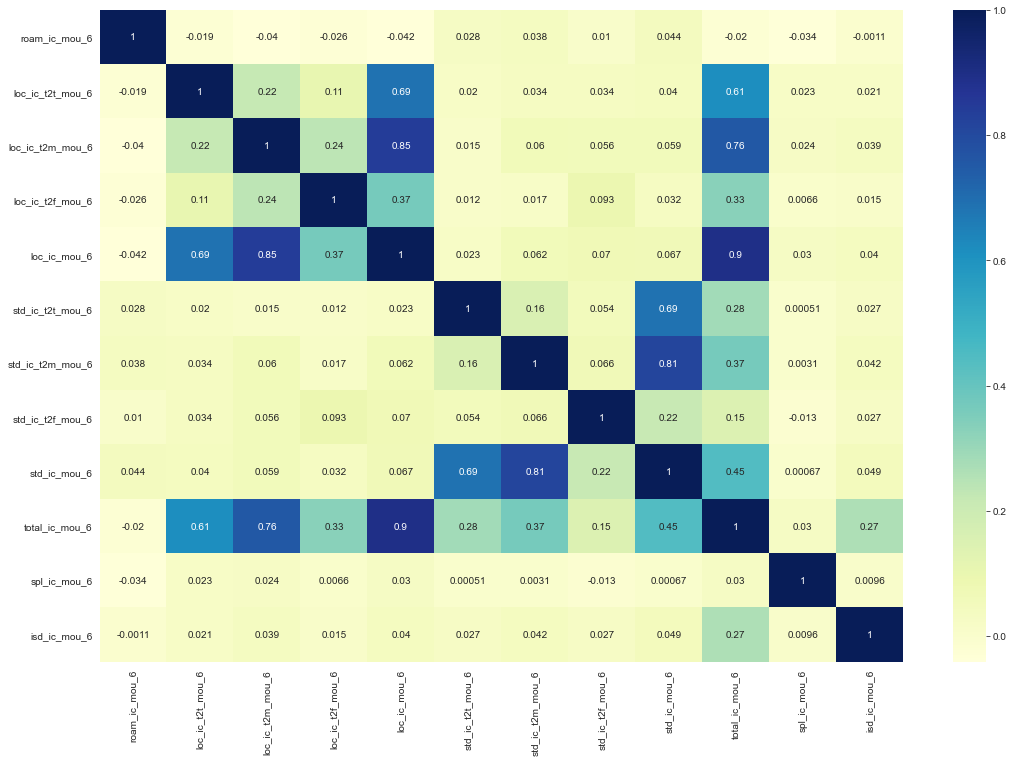

In [70]:
# Correlation matrix for mou 6th month
heatmap(18,12,telecom_high_val_cust.filter(mou_ic_cols6))

`Inference:`
- We can see that total_ic_mou_6, std_ic_mou_6 and loc_ic_mou_6 have high correlations with some variables and they should be inspected.

In [71]:
# Dropping columns ic_mou since they are a combination of other variables present in the data.
list_total_ic_cols = telecom_high_val_cust.columns[telecom_high_val_cust.columns.str.contains('total_ic_mou|std_ic_mou|loc_ic_mou',regex=True)]
telecom_high_val_cust.drop(list_total_ic_cols,axis=1,inplace=True)
print('Columns Dropped:')
list_total_ic_cols.tolist()

Columns Dropped:


['loc_ic_mou_6',
 'loc_ic_mou_7',
 'loc_ic_mou_8',
 'std_ic_mou_6',
 'std_ic_mou_7',
 'std_ic_mou_8',
 'total_ic_mou_6',
 'total_ic_mou_7',
 'total_ic_mou_8']

In [72]:
# Offnet Usage
offnet_usage_service_col = telecom_high_val_cust.columns[telecom_high_val_cust.columns.str.contains('offnet.*mou',regex=True)]

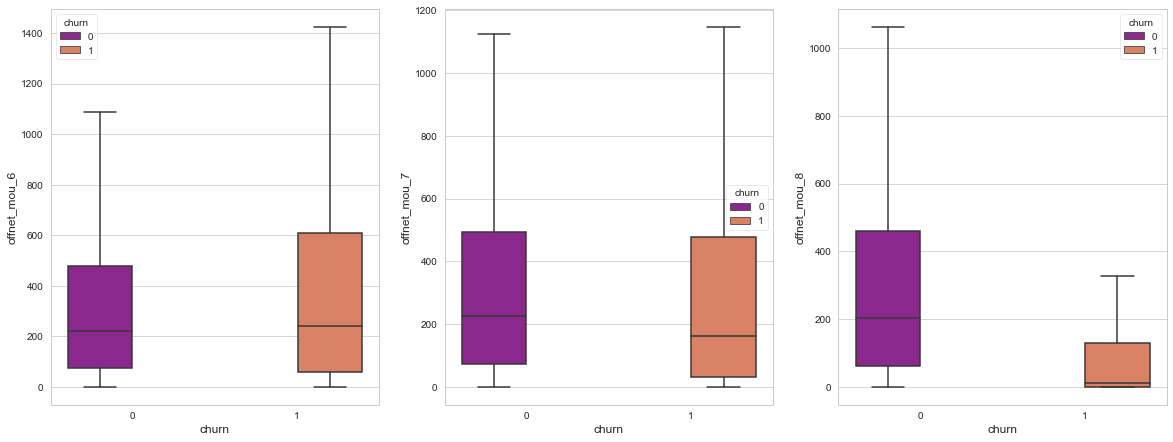

In [73]:
# Offnet mou for churned v/s non-churned
plot_box_chart('offnet_mou')

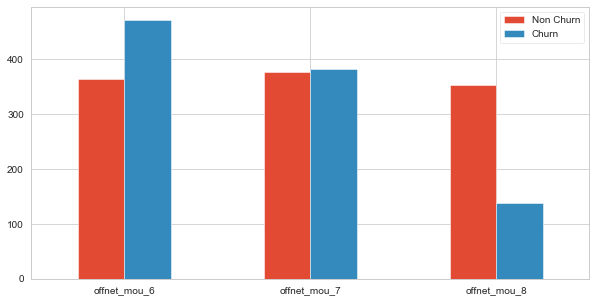

,offnet_mou_6,offnet_mou_7,offnet_mou_8
Non Churn,365.123076,377.875572,352.504090
Churn,471.950838,382.277222,138.523181


In [74]:
plot_mean_bar_chart(telecom_high_val_cust, offnet_usage_service_col)

`Inference:` We can see the drop in the 8th month.

In [75]:
# Onnet
onnet_usage_service =  telecom_high_val_cust.columns[telecom_high_val_cust.columns.str.contains('^onnet.*mou',regex=True)]
onnet_usage_service

Index(['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8'], dtype='object')

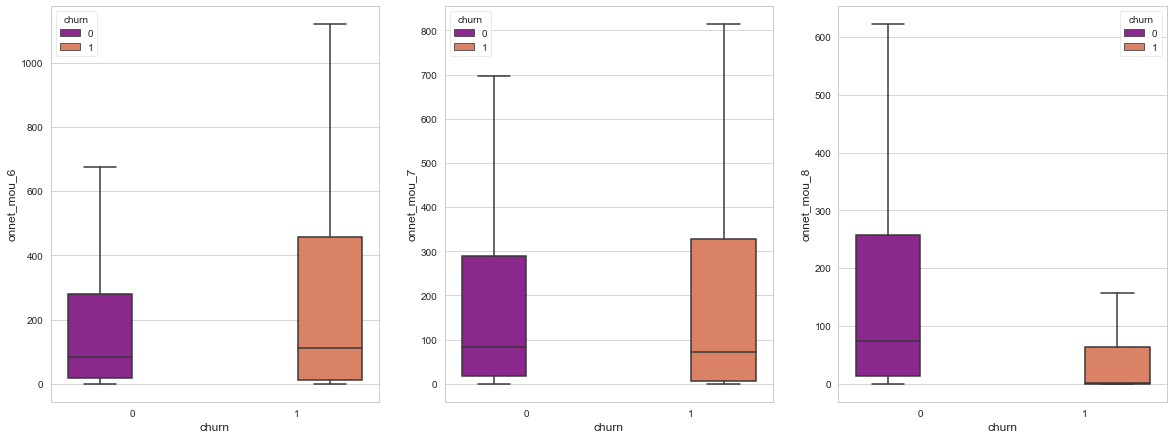

In [76]:
# Onnet
plot_box_chart('onnet_mou')

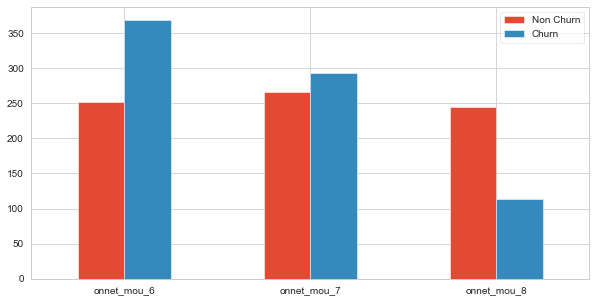

,onnet_mou_6,onnet_mou_7,onnet_mou_8
Non Churn,251.374116,265.859670,245.030935
Churn,368.659420,292.846601,113.478011


In [77]:
plot_mean_bar_chart(telecom_high_val_cust, onnet_usage_service)

In [78]:
# Tenure Analysis
tenure_data = telecom_high_val_cust.copy()

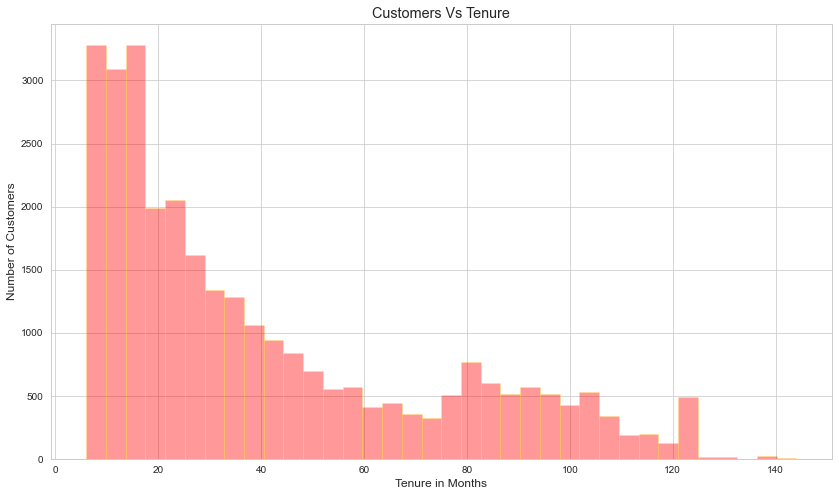

In [79]:
plt.figure(figsize=(14,8))
# Age on network: aon - number of days the customer is using the operator T network
tenure_data['tenure'] = tenure_data['aon']/30
tenure_data['tenure'].head()
ax = sns.distplot(tenure_data['tenure'], hist=True, kde=False, 
             bins=int(180/5), color = 'red', 
             hist_kws={'edgecolor':'yellow'},
             kde_kws={'linewidth': 4})
ax.set_ylabel('Number of Customers')
ax.set_xlabel('Tenure in Months')
ax.set_title('Customers Vs Tenure')
plt.show()

In [80]:
# Binning
tn_range = [0, 6, 12, 24, 60, 61]
tn_label = ['0-6 Months', '6-12 Months', '1-2 Yrs', '2-5 Yrs', '5 Yrs and above']
tenure_data['tenure_range'] = pd.cut(tenure_data['tenure'], tn_range, labels=tn_label)
tenure_data['tenure_range'].head()

0         2-5 Yrs
7         2-5 Yrs
8     6-12 Months
21        1-2 Yrs
23        1-2 Yrs
Name: tenure_range, dtype: category
Categories (5, object): ['0-6 Months' < '6-12 Months' < '1-2 Yrs' < '2-5 Yrs' < '5 Yrs and above']

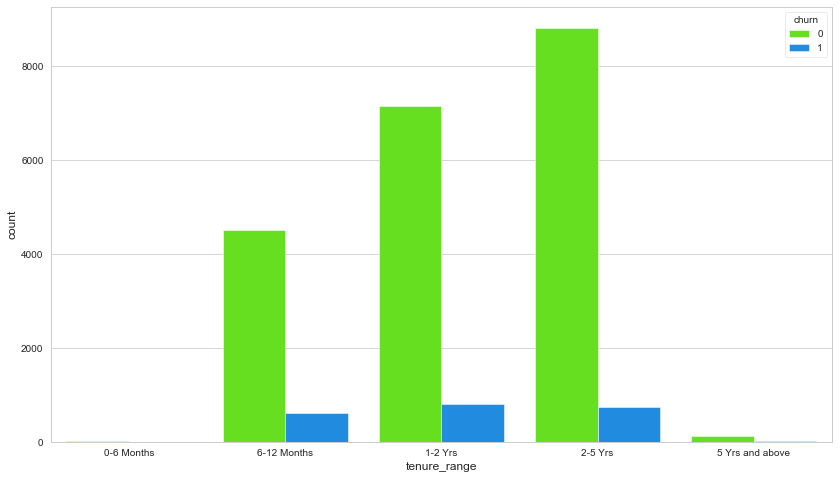

In [81]:
plt.figure(figsize=(14,8))
sns.countplot(x = 'tenure_range', hue = 'churn',data = tenure_data,palette=("gist_rainbow"))
plt.show()

In [82]:
# Checking columns with more than 30% missing values
info_df = get_info(telecom_high_val_cust)
info_df = info_df[info_df["Null_Percentage"] > 30]
info_df.sort_values(["Null_Percentage"], axis=0,ascending=False, inplace=True)
col_to_display = ['Null_Percentage']
info_df[col_to_display]

,Null_Percentage
date_of_last_rech_data_8,46.799987
night_pck_user_8,46.799987
fb_user_8,46.799987
date_of_last_rech_data_6,44.112443
night_pck_user_6,44.112443
fb_user_6,44.112443
date_of_last_rech_data_7,43.117551
night_pck_user_7,43.117551
fb_user_7,43.117551


In [83]:
# Dropping columns with more than 30% missing values
is_more_30 = info_df.index
telecom_high_val_cust.drop(telecom_high_val_cust[is_more_30],axis=1,inplace=True)
print('Shape:', telecom_high_val_cust.shape)

Shape: (29953, 124)


In [84]:
# Missing Value Percentage
info_df = get_info(telecom_high_val_cust)
info_df = info_df[info_df["Null_Percentage"] > 0]
info_df.sort_values(["Null_Percentage"], axis=0,ascending=False, inplace=True)
col_to_display = ['Null_Percentage']
info_df[col_to_display]

,Null_Percentage
og_others_8,3.912797
ic_others_8,3.912797
date_of_last_rech_8,1.943044
og_others_6,1.809502
ic_others_6,1.809502
og_others_7,1.789470
ic_others_7,1.789470
date_of_last_rech_7,0.327179
date_of_last_rech_6,0.243715


In [85]:
# Exploring Numeric Fields
num_col = ['og_others_8', 'ic_others_8', 'og_others_6','ic_others_6', 'og_others_7', 'ic_others_7']

In [86]:
# Replacing Missing Value with 0
for i in num_col:
    telecom_high_val_cust.loc[telecom_high_val_cust[i].isnull(),i]=0

In [87]:
# Missing Value Percentage
info_df = get_info(telecom_high_val_cust)
info_df = info_df[info_df["Null_Percentage"] > 0]
info_df.sort_values(["Null_Percentage"], axis=0,ascending=False, inplace=True)
col_to_display = ['Null_Percentage']
info_df[col_to_display]

,Null_Percentage
date_of_last_rech_8,1.943044
date_of_last_rech_7,0.327179
date_of_last_rech_6,0.243715


## 5. Feature Engineering

In [88]:
telecom_df_final = telecom_high_val_cust.copy()
print('Shape:', telecom_df_final.shape)

Shape: (29953, 124)


In [89]:
telecom_df_final.drop(["total_avg_rech_amt_6_7_GPhase"],axis=1,inplace=True)
telecom_df_final.drop(telecom_high_val_cust.filter(regex='date_').columns,axis=1,inplace=True)
print (telecom_df_final.shape)

col_list = telecom_df_final.filter(regex='_6|_7').columns.str[:-2]
for idx, col in enumerate(col_list.unique()):
    print(col)
    avg_col_name = "avg_"+col+"_av67"
    col_6 = col+"_6"
    col_7 = col+"_7"
    telecom_df_final[avg_col_name] = (telecom_df_final[col_6]  + telecom_df_final[col_7])/ 2

(29953, 120)
arpu
onnet_mou
offnet_mou
roam_ic_mou
roam_og_mou
loc_og_t2t_mou
loc_og_t2m_mou
loc_og_t2f_mou
loc_og_t2c_mou
std_og_t2t_mou
std_og_t2m_mou
std_og_t2f_mou
isd_og_mou
spl_og_mou
og_others
loc_ic_t2t_mou
loc_ic_t2m_mou
loc_ic_t2f_mou
std_ic_t2t_mou
std_ic_t2m_mou
std_ic_t2f_mou
spl_ic_mou
isd_ic_mou
ic_others
total_rech_num
total_rech_amt
max_rech_amt
last_day_rch_amt
total_rech_data
max_rech_data
av_rech_amt_data
vol_2g_mb
vol_3g_mb
monthly_2g
sachet_2g
monthly_3g
sachet_3g
vbc_3g
total_rech_amt_data


In [90]:
col_list_to_drop = telecom_df_final.filter(regex='_6|_7')
telecom_df_final.drop(col_list_to_drop,axis=1,inplace=True)
print ('Shape:', telecom_df_final.shape)

Shape: (29953, 81)


`Inference:`
- We have merged most of the columns of 6th and 7th month since they have similar performance and also to reduce the number of features.

## 6. Modelling

### 6.1. PCA: Principal Component Analysis

In [91]:
telecom_pca_df = telecom_df_final.copy()

In [92]:
# Defining some customised functions

def scale_data(X):
    scaler = StandardScaler()
    X_col = X.columns
    X_scaled = scaler.fit_transform(X)
    X_scale_final = pd.DataFrame(X_scaled, columns=X_col)
    return X_scale_final

def get_scree_plot(X):
    pca = PCA(svd_solver='randomized', random_state=101)
    pca.fit(X)
    fig = plt.figure(figsize = (8,6))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.show()
    return pca
    
    
def resampling_data(X,Y,feature_number,train_size=0.7,test_size=0.3) :
    
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, train_size=train_size, random_state=1)
    print('Shape of train dataset before PCA:', str(x_train.shape))
    print('Percentage of Churned customer data:', str(round(100*Y.sum()/len(Y), 2)))
    print('Aplying SMOTE to normalize imbalace.')

    #Initializing SMOTE: Synthetic Minority Over-sampling Technique
    # using this as data is skewed 
    smote = SMOTE(kind = "regular")
    x_tr,y_tr = smote.fit_sample(x_train,y_train)
    print('Shape of train dataset after SMOTE: ', str(x_tr.shape))
    
    # Applying PCA : Pricnipal Component Analysis
    pca = IncrementalPCA(n_components=feature_number)    
    x_tr_pca = pca.fit_transform(x_tr)
    x_test_pca = pca.transform(x_test)
    
    print('Shape of train dataset after PCA:', str(x_train.shape))
    
    return x_tr_pca,x_test_pca,y_tr,y_test

In [93]:
Y = telecom_pca_df["churn"]
X = telecom_pca_df.drop(["churn","mobile_number"],axis=1)

In [94]:
print('Customer Churn Percentage:', round((Y.sum()/len(Y))*100,2), '%')

Customer Churn Percentage: 8.12 %


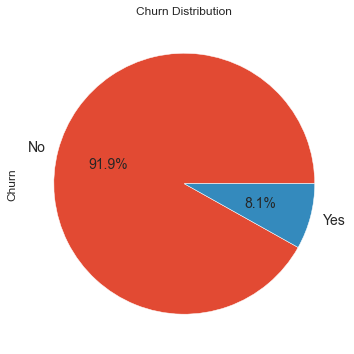

In [95]:
# Churn Distribution
pie_chart = telecom_pca_df['churn'].value_counts()*100.0 /len(telecom_pca_df)
ax = pie_chart.plot.pie(autopct='%.1f%%', labels = ['No', 'Yes'],figsize =(8,6), fontsize = 14 )                                                                           
ax.set_ylabel('Churn',fontsize = 12)
ax.set_title('Churn Distribution', fontsize = 12)
plt.show()

In [96]:
# Scaling the data
X_scaled = scale_data(X)
print(X_scaled.shape)
X_scaled.head(5)

(29953, 79)


,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,total_rech_data_8,max_rech_data_8,av_rech_amt_data_8,vol_2g_mb_8,vol_3g_mb_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,aon,vbc_3g_8,total_rech_amt_data_8,avg_arpu_av67,avg_onnet_mou_av67,avg_offnet_mou_av67,avg_roam_ic_mou_av67,avg_roam_og_mou_av67,avg_loc_og_t2t_mou_av67,avg_loc_og_t2m_mou_av67,avg_loc_og_t2f_mou_av67,avg_loc_og_t2c_mou_av67,avg_std_og_t2t_mou_av67,avg_std_og_t2m_mou_av67,avg_std_og_t2f_mou_av67,avg_isd_og_mou_av67,avg_spl_og_mou_av67,avg_og_others_av67,avg_loc_ic_t2t_mou_av67,avg_loc_ic_t2m_mou_av67,avg_loc_ic_t2f_mou_av67,avg_std_ic_t2t_mou_av67,avg_std_ic_t2m_mou_av67,avg_std_ic_t2f_mou_av67,avg_spl_ic_mou_av67,avg_isd_ic_mou_av67,avg_ic_others_av67,avg_total_rech_num_av67,avg_total_rech_amt_av67,avg_max_rech_amt_av67,avg_last_day_rch_amt_av67,avg_total_rech_data_av67,avg_max_rech_data_av67,avg_av_rech_amt_data_av67,avg_vol_2g_mb_av67,avg_vol_3g_mb_av67,avg_monthly_2g_av67,avg_sachet_2g_av67,avg_monthly_3g_av67,avg_sachet_3g_av67,avg_vbc_3g_av67,avg_total_rech_amt_data_av67
0,-0.587674,-0.510841,-0.695309,-0.168679,-0.189787,-0.343476,-0.649478,-0.301900,-0.238110,-0.373493,-0.384626,-0.145041,-0.043625,-0.322777,-0.01739,-0.393039,-0.661296,-0.306103,-0.194993,-0.270094,-0.128812,-0.239999,-0.155900,-0.095845,-0.859812,-0.544124,0.529591,1.098537,-0.207844,1.622450,0.663408,-0.319829,-0.263422,-0.377738,-0.416099,1.276531,-0.183926,-0.252008,-0.329779,-0.130336,-0.822740,-0.601302,-0.821237,-0.217580,-0.250490,-0.382885,-0.702523,-0.304606,-0.26747,-0.440961,-0.466159,-0.157504,-0.047861,-0.373455,-0.142827,-0.420301,-0.729516,-0.353064,-0.201905,-0.319361,-0.153462,-0.268081,-0.154826,-0.096699,-0.959891,-0.686829,0.526201,1.304802,-0.281673,1.675546,0.640631,-0.367143,-0.286068,-0.461204,-0.472415,1.358301,-0.230564,-0.301013,-0.194187
1,5.302613,-0.396856,-0.019115,0.257863,0.173388,-0.166450,0.044793,2.425615,-0.238110,-0.343304,-0.264487,1.379645,0.180077,-0.002416,-0.01739,-0.222309,-0.116813,0.579561,0.230718,1.097095,0.986581,-0.239999,0.291204,1.087598,-0.320785,4.993406,8.192812,4.726892,-0.541457,-0.655815,-0.624657,-0.338197,-0.382626,-0.377738,-0.416099,-0.341921,-0.183926,-0.425388,-0.264857,-0.285526,1.510046,-0.473392,0.293269,0.158438,-0.055836,-0.196834,0.924680,2.491601,-0.26747,-0.405208,-0.362562,1.001249,-0.045850,-0.243500,-0.142827,-0.132885,0.330406,2.504287,0.122424,0.842484,2.257838,0.428547,-0.041645,1.028963,-0.786191,1.016523,6.573427,-0.867797,-0.650953,-0.765285,-0.743309,-0.419584,-0.425468,-0.461204,-0.472415,-0.391449,-0.230564,-0.381270,-0.397513
2,-0.739908,-0.434372,-0.412142,-0.168679,-0.189787,-0.288584,-0.433257,-0.301900,0.762241,-0.316735,-0.199578,-0.145041,-0.043625,0.181421,-0.01739,-0.392096,-0.608504,-0.332641,-0.193592,-0.263806,-0.128812,-0.239999,-0.155900,-0.095845,0.433852,-0.760000,-0.751459,-0.567614,0.459382,-0.447878,-0.271972,-0.338101,-0.369641,-0.377738,0.766276,-0.341921,-0.183926,-0.934039,-0.352029,-0.158048,-0.289486,0.268015,-0.629816,-0.217580,-0.250490,0.774107,-0.376355,-0.304606,-0.26747,-0.117001,-0.436051,-0.157504,-0.047861,-0.373455,-0.142827,-0.313219,-0.556761,-0.353064,-0.198044,-0.178353,-0.153462,-0.268081,-0.154826,-0.096699,0.950807,-0.275541,-0.316392,-0.652262,-0.281673,-0.019475,-0.257283,0.174018,0.021262,0.828299,-0.265486,-0.391449,-0.230564,0.884275,-0.254701
3,0.256647,-0.325248,1.345016,-0.168679,-0.189787,-0.240899,-0.201077,-0.220941,-0.238110,-0.218176,1.759453,-0.145041,-0.043625,-0.322777,-0.01739,-0.271170,-0.079742,-0.092879,-0.192471,0.714112,-0.128812,-0.239999,-0.155900,-0.095845,1.

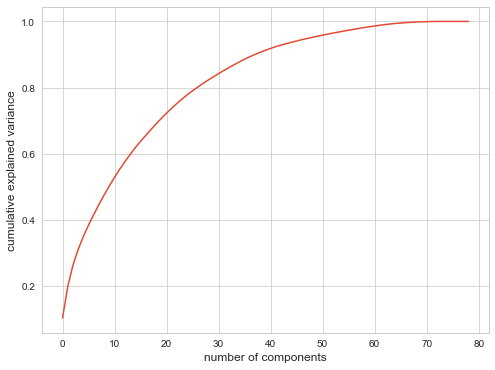

,PC1,PC2,PC3,Feature
0,0.000556,0.294716,0.154905,arpu_8
1,-0.112810,0.114988,0.149637,onnet_mou_8
2,-0.104630,0.199573,0.114285,offnet_mou_8
3,-0.007768,0.050446,0.007028,roam_ic_mou_8
4,-0.022813,0.069574,0.029853,roam_og_mou_8
5,-0.030653,0.098338,0.024347,loc_og_t2t_mou_8
6,-0.031542,0.176698,-0.027159,loc_og_t2m_mou_8
7,0.009128,0.109241,-0.091910,loc_og_t2f_mou_8
8,-0.014519,0.015865,0.079296,loc_og_t2c_mou_8
9,-0.109851,0.069713,0.155442,std_og_t2t_mou_8


In [97]:
pca = get_scree_plot(X_scaled) # scree plot

col = list(X_scaled.columns)
df_pca = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'PC3':pca.components_[2],'Feature':col})
df_pca.head(10)

In [98]:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([ 10.34,  19.83,  26.28,  31.01,  34.99,  38.42,  41.6 ,  44.64,
        47.53,  50.26,  52.88,  55.32,  57.61,  59.77,  61.85,  63.73,
        65.53,  67.3 ,  69.04,  70.69,  72.3 ,  73.81,  75.24,  76.57,
        77.88,  79.06,  80.18,  81.26,  82.3 ,  83.28,  84.23,  85.16,
        86.06,  86.95,  87.79,  88.58,  89.34,  90.04,  90.69,  91.3 ,
        91.86,  92.4 ,  92.88,  93.3 ,  93.71,  94.11,  94.5 ,  94.86,
        95.2 ,  95.54,  95.87,  96.18,  96.49,  96.79,  97.07,  97.35,
        97.63,  97.9 ,  98.16,  98.4 ,  98.63,  98.84,  99.05,  99.23,
        99.39,  99.52,  99.64,  99.75,  99.85,  99.9 ,  99.94,  99.98,
       100.  , 100.01, 100.01, 100.01, 100.01, 100.01, 100.01])

`Inference:` We can see that 60 components are enough to explain 95% of the variance.

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled,Y,train_size = 0.7)
X_train.shape

(20967, 79)

In [100]:
# Defining a custom function to print model metrics
def print_model_metrics(y_test,y_pred,model_name):
    print('Model Stats Score Summary: ')
    cp = confusion_matrix(y_test,y_pred)
    plt.figure()
    confusion_matrix_plot(cp)
    plt.show()
    
    accuracy = round(accuracy_score(y_test,y_pred),2)
    recall = round(recall_score(y_test,y_pred),2)
    precision = round(precision_score(y_test,y_pred),2)
    auc = round(roc_auc_score(y_test,y_pred),2)
    f1 = round(f1_score(y_test,y_pred),2)
    
    data = [[model_name,accuracy,recall,precision,auc,f1]] 
    df = pd.DataFrame(data, columns = ['Model', 'Accuracy','Precision','Recall','AUC','F1'])
    add_to_global_summary(df)
    return df 

def confusion_matrix_plot(cm):
    classes=[0,1]
    cmap=plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

model_summary = pd.DataFrame()

def add_to_global_summary(df) :
    global model_summary 
    model_summary = model_summary.append(df,ignore_index=True)

### 6.2. Logistic Regression Model

In [101]:
# Training the model
lr = LogisticRegression()
model = lr.fit(X_train,y_train)
#Making prediction on the test data
pred_probs_test = model.predict_proba(X_test)[:,1]

In [102]:
# Logistic Regression Accuracy
print('Accuracy:', metrics.roc_auc_score(y_test, pred_probs_test))

Accuracy: 0.8881385948412142


### 6.3. RandomForest Model

In [103]:
# Creating a backup copy
telecom_tree_df = telecom_df_final.copy()

In [104]:
telecom_tree_df.head()

,mobile_number,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,total_rech_data_8,max_rech_data_8,av_rech_amt_data_8,vol_2g_mb_8,vol_3g_mb_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,aon,vbc_3g_8,total_rech_amt_data_8,churn,avg_arpu_av67,avg_onnet_mou_av67,avg_offnet_mou_av67,avg_roam_ic_mou_av67,avg_roam_og_mou_av67,avg_loc_og_t2t_mou_av67,avg_loc_og_t2m_mou_av67,avg_loc_og_t2f_mou_av67,avg_loc_og_t2c_mou_av67,avg_std_og_t2t_mou_av67,avg_std_og_t2m_mou_av67,avg_std_og_t2f_mou_av67,avg_isd_og_mou_av67,avg_spl_og_mou_av67,avg_og_others_av67,avg_loc_ic_t2t_mou_av67,avg_loc_ic_t2m_mou_av67,avg_loc_ic_t2f_mou_av67,avg_std_ic_t2t_mou_av67,avg_std_ic_t2m_mou_av67,avg_std_ic_t2f_mou_av67,avg_spl_ic_mou_av67,avg_isd_ic_mou_av67,avg_ic_others_av67,avg_total_rech_num_av67,avg_total_rech_amt_av67,avg_max_rech_amt_av67,avg_last_day_rch_amt_av67,avg_total_rech_data_av67,avg_max_rech_data_av67,avg_av_rech_amt_data_av67,avg_vol_2g_mb_av67,avg_vol_3g_mb_av67,avg_monthly_2g_av67,avg_sachet_2g_av67,avg_monthly_3g_av67,avg_sachet_3g_av67,avg_vbc_3g_av67,avg_total_rech_amt_data_av67
0,7000842753,213.803,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.16,4.13,1.15,0.00,0.00,0.00,0.0,0.00,0.00,2,252,252,252,1.0,252.0,252.0,5.75,109.61,0,0,1,0,968,30.40,252.0,1,206.1005,0.00,0.000,0.00,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.00,0.000,0.00,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.5,307.0,252.0,252.0,1.0,252.0,252.0,15.725,117.165,0.0,0.0,1.0,0.0,50.600,252.0
7,7000701601,3171.480,52.29,325.91,31.64,38.06,40.28,162.28,53.23,0.00,12.01,49.14,16.68,10.01,6.50,0.0,27.31,121.19,39.53,30.39,141.33,22.21,0.0,31.59,15.14,7,3638,1580,779,0.0,0.0,0.0,0.00,0.00,0,0,0,0,802,57.74,0.0,1,1209.5150,56.26,510.295,24.86,18.165,41.385,378.005,58.635,0.0,13.795,40.825,13.37,0.090,2.25,0.0,45.200,219.525,126.810,24.360,109.215,43.215,0.105,8.295,15.465,5.0,1185.0,1185.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,19.060,0.0
8,7001524846,137.362,35.08,136.48,0.00,0.00,12.49,50.54,0.00,7.15,22.58,75.69,0.00,0.00,10.23,0.0,0.31,15.48,0.00,0.10,0.65,0.00,0.0,0.00,0.00,14,120,30,10,3.0,23.0,69.0,0.03,11.94,0,3,0,0,315,21.03,207.0,0,435.4720,382.36,87.645,0.00,0.000,257.360,75.770,0.000,0.0,124.995,11.865,0.00,0.000,0.00,0.0,16.840,35.780,0.000,0.290,13.255,0.000,0.000,0.000,0.000,20.0,519.0,122.0,25.0,1.0,77.0,88.5,178.000,375.475,0.5,0.5,0.0,0.0,516.405,177.0
21,7002124215,637.760,85.14,983.39,0.00,0.00,23.34,104.81,1.58,0.00,61.79,876.99,0.00,0.00,0.00,0.0,19.54,129.16,10.39,0.18,101.74,0.00,0.0,0.00,0.00,27,718,50,50,0.0,0.0,0.0,0.00,0.00,0,0,0,0,720,0.00,0.0,0,556.1030,117.26,827.305,0.00,0.000,5.320,89.870,0.375,0.0,111.935,737.050,0.00,0.000,0.00,0.0,6.335,96.430,3.725,10.020,52.960,0.000,0.000,0.000,0.000,24.0,640.0,50.0,25.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.000,0.0
23,7000887461,366.966,33.58,205.89,0.00,0.00,33.58,148.56,0.00,17.71,0.00,39.61,0.00,0.00,17.71,0.0,76.64,146.84,0.71,13.38,43.91,0.00,0.0,3.74,13.06,4,439,179,0,2.0,179.0,270.0,0.01,1009.92,0,0,1,1,604,40.45,540.0,0,134.1235,49.81,87.385,0.00,0.000,49.810,82.975,0.000,0.0,0.000,4.355,0.00,0.005,0.05,0.0,40.875,104.635,0.000,0.255,8.660,0.000,0.000,14.115,2.675,4.0,227.0,89.5,89.5,1.0,89.5,178.0,0.240,299.545,0.0,0.0,1.0,0.0,25.930,356.0


In [105]:
# Splitting the data into X and y
y = telecom_tree_df["churn"]
X = telecom_tree_df.drop(["churn","mobile_number"],axis=1)

In [106]:
# Splittimg into Train and Test
X_train, X_test, y_train, y_test = train_test_split(scale_data(X), y, train_size=0.70, random_state=100)

In [107]:
# Fitting the train and test
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)

RandomForestClassifier()

In [108]:
# Predictions
y_pred_test = rfc.predict(X_test)

Model Stats Score Summary: 


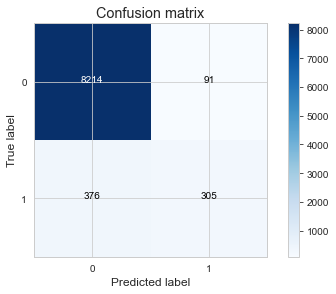

,Model,Accuracy,Precision,Recall,AUC,F1
0,RandomForest (Default),0.95,0.45,0.77,0.72,0.57


In [109]:
print_model_metrics(y_test,y_pred_test,"RandomForest (Default)")

#### Hyperparameter Tuning

In [110]:
# GridSearch
param_grid = {
    'max_depth': [12,18],
    'n_estimators': [200],
    'max_features': [40],
    'min_samples_leaf': [10, 20],
    'min_samples_split': [10,20,30]
}

# Initializing the model
rf = RandomForestClassifier()
# Instantiate the grid search model
rf_grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1,verbose = 1,return_train_score=True)

`Note:` After some testing, we have arrived to the above parameters. Here, it is not shown because it takes a lot of time in running that code.

In [111]:
# Fitting the grid search to the data
rf_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [12, 18], 'max_features': [40],
                         'min_samples_leaf': [10, 20],
                         'min_samples_split': [10, 20, 30],
                         'n_estimators': [200]},
             return_train_score=True, verbose=1)

In [112]:
# Accuracy Score
print('Accuracy Score:',round(rf_grid_search.best_score_, 2))

Accuracy Score: 0.94


#### Building and Evaluating Final model for Random Forest

In [113]:
rfc = RandomForestClassifier(max_depth=18,
                             max_features=40,
                             min_samples_leaf=10,
                             min_samples_split=20,
                             n_estimators=200,
                             n_jobs = -1)
rfc.fit(X_train,y_train)

RandomForestClassifier(max_depth=18, max_features=40, min_samples_leaf=10,
                       min_samples_split=20, n_estimators=200, n_jobs=-1)

In [114]:
# Predictions
y_pred_test = rfc.predict(X_test)

Model Stats Score Summary: 


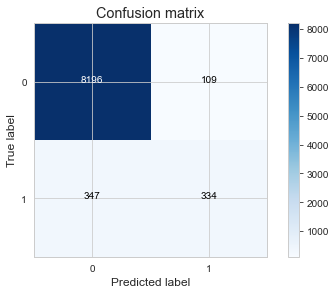

,Model,Accuracy,Precision,Recall,AUC,F1
0,RandomForest (Hyper),0.95,0.49,0.75,0.74,0.59


In [115]:
# Confusion Matrix
print_model_metrics(y_test,y_pred_test,'RandomForest (Hyper)')

### 6.4. XGBOOST

In [116]:
# Creating a backup copy to run on this model
telecom_xgboost_df = telecom_df_final.copy()

In [117]:
# Splitting into X and y
y = telecom_xgboost_df["churn"]
X = telecom_xgboost_df.drop(["churn","mobile_number"],axis=1)

In [118]:
# Splitting into Train and Test
X_train, X_test, y_train, y_test = train_test_split(scale_data(X), y, train_size=0.7, random_state=100)

In [119]:
# Fitting the Training data on XGBOOST model
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

[20:37:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [120]:
# Predictions
y_pred_test = xgb_model.predict(X_test)

Model Stats Score Summary: 


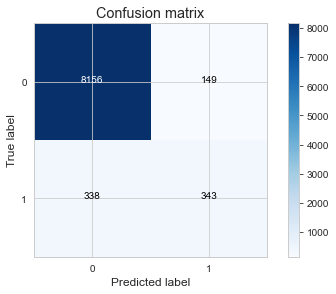

,Model,Accuracy,Precision,Recall,AUC,F1
0,XGBoost (Default),0.95,0.5,0.7,0.74,0.58


In [121]:
# Model Metrics and Accuracy Score
print_model_metrics(y_test, y_pred_test ,'XGBoost (Default)')

#### Hyperparameteric Tuning

In [122]:
# KFold 
folds = 5

# Hyperparameters
param_grid = {'learning_rate': [0.1,0.2,0.3], 
             'subsample': [0.3,0.4,0.5]}          


# Model Initialization
xgb_model = XGBClassifier(max_depth=2, n_estimators=200)

# GridSearchCV()
model_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'accuracy', # accuracy
                        cv = folds, 
                        n_jobs = -1,
                        verbose = 1,
                        return_train_score=True)  

In [123]:
# Fitting the model
model_cv.fit(X_train, y_train)    

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[20:38:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=2, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=200, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, va

In [124]:
# Cross-Validation Results
cv_results_xgboost = pd.DataFrame(model_cv.cv_results_)
cv_results_xgboost['param_learning_rate'] = cv_results_xgboost['param_learning_rate'].astype('float')

In [125]:
# Accuracy Score
print('Accuracy Score:', round(model_cv.best_score_, 2))

Accuracy Score: 0.94


In [126]:
# Customized function for plotting XGBOOST
def plot_for_xboost(param_grid,cv_results):
    plt.figure(figsize=(18,5))
    for n, subsample in enumerate(param_grid['subsample']):
        # subplot 1/n
        plt.subplot(1,len(param_grid['subsample']), n+1)
        df = cv_results[cv_results['param_subsample']==subsample]

        plt.plot(df["param_learning_rate"], df["mean_test_score"])
        plt.plot(df["param_learning_rate"], df["mean_train_score"])
        plt.xlabel('learning_rate')
        plt.ylabel('AUC')
        plt.title("subsample={0}".format(subsample))
        plt.ylim([0.60, 1])
        plt.legend(['test score', 'train score'], loc='lower right')
        plt.xscale('log')

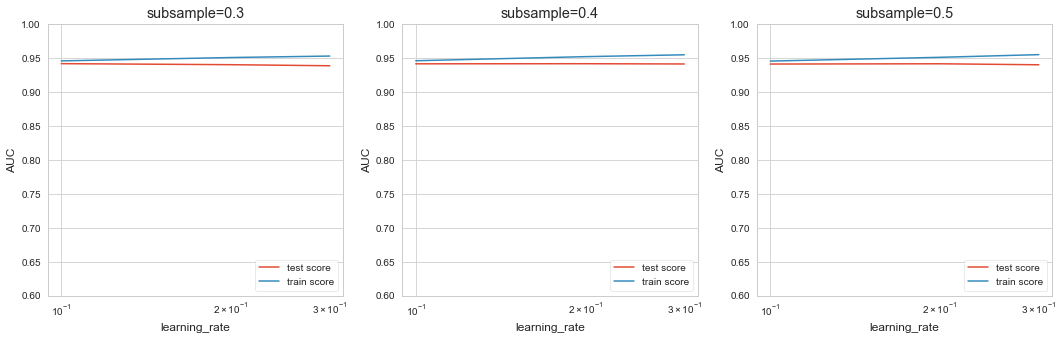

In [127]:
param_grid1 = {'learning_rate': [0.1,0.2,0.3], 'subsample': [0.3,0.4,0.5]}  
plot_for_xboost(param_grid1,cv_results_xgboost)

`Inference:`
- Results show that subsample size of 0.5 and learning_rate of 0.3 seems optimal.

In [128]:
# Chosen Hyperparameters
# 'objective':'binary:logistic' outputs probability rather than label, which we need for auc
params = {'learning_rate': [0.3],
          'max_depth': [2], 
          'n_estimators':[200],
          'subsample':[0.5],
         'objective':['binary:logistic']}

# fit model on training data
model = XGBClassifier(params = params,max_depth=2, n_estimators=200)
model.fit(X_train, y_train)

[20:38:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:38:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=16, num_parallel_tree=1,
              params={'learning_rate': [0.3], 'max_depth': [2],
                      'n_estimators': [200], 'objective': ['binary:logistic'],
                      'subsample': [0.5]},
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [129]:
# Predictions
y_pred_test = model.predict(X_test)

Model Stats Score Summary: 


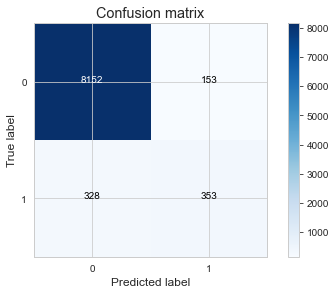

,Model,Accuracy,Precision,Recall,AUC,F1
0,XGBoost (Hyper Tuned),0.95,0.52,0.7,0.75,0.59


In [130]:
print_model_metrics(y_test, y_pred_test,'XGBoost (Hyper Tuned)')

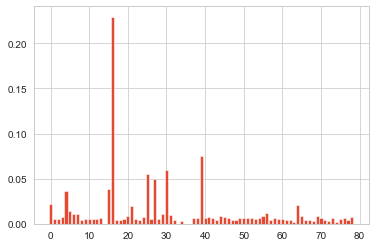

In [131]:
# Plotting Feature Importances
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

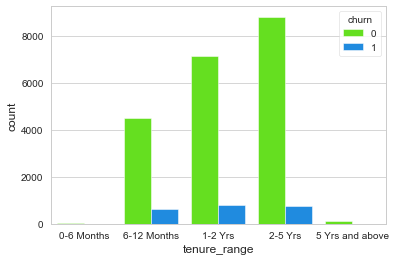

Important Indicators:


,PC1,PC2,PC3,Feature
0,0.000556,0.294716,0.154905,arpu_8
1,-0.112810,0.114988,0.149637,onnet_mou_8
2,-0.104630,0.199573,0.114285,offnet_mou_8
3,-0.007768,0.050446,0.007028,roam_ic_mou_8
4,-0.022813,0.069574,0.029853,roam_og_mou_8
5,-0.030653,0.098338,0.024347,loc_og_t2t_mou_8
6,-0.031542,0.176698,-0.027159,loc_og_t2m_mou_8
7,0.009128,0.109241,-0.091910,loc_og_t2f_mou_8
8,-0.014519,0.015865,0.079296,loc_og_t2c_mou_8
9,-0.109851,0.069713,0.155442,std_og_t2t_mou_8


In [132]:
plt.figure(figsize=(6,4))
sns.countplot(x = 'tenure_range', hue = 'churn',data = tenure_data,palette=("gist_rainbow"))
plt.show()

print('Important Indicators:')
col = list(X_scaled.columns)
df_pca = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'PC3':pca.components_[2],'Feature':col})
df_pca.head(15)

## 7. Recommendations

`Inference:`
- Less number of 'High Value Customers' are churning but for last 6 month, no new high valued customer is onboarded which the company should look into.
- Customers with less than 4 years of tenure are more likely to churn.
- Average Revenue per user is the most important feature.
- Incoming and Outgoing Calls in 8th month should be focused on because if their usage is decreased, they are more likely to churn.
- 2G/3G services should be improved.

In [133]:
model_summary

,Model,Accuracy,Precision,Recall,AUC,F1
0,RandomForest (Default),0.95,0.45,0.77,0.72,0.57
1,RandomForest (Hyper),0.95,0.49,0.75,0.74,0.59
2,XGBoost (Default),0.95,0.50,0.70,0.74,0.58
3,XGBoost (Hyper Tuned),0.95,0.52,0.70,0.75,0.59


`Inference:`
- RandomForest produce good accuracy of 0.95.
- XGBOOST after tuning also produce an accuracy of 0.95.
- We should prefer XGBOOST with parameters tuned for future predictions of the model.